<a href="https://colab.research.google.com/github/TakshPanchal/jax_notebooks/blob/main/simple_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement two hidden layers neural network classifier from scratch in JAX [20 Marks]

- [ ] Two hidden layers here means (input - hidden1 - hidden2 - output).
- [X]  You must not use flax, optax, or any other library for this task.
- [X]  Use MNIST dataset with 80:20 train:test split.
- [ ]  Manually optimize the number of neurons in hidden layers.
- [ ]  Use gradient descent from scratch to optimize your network. You should use the Pytree concept of JAX to do this elegantly.
- [ ]  Plot loss v/s iterations curve with matplotlib.
- [ ]  Evaluate the model on test data with various classification metrics and briefly discuss their implications.


In [1]:
# TODO: implement NN
# TODO: implement GD
# TODO: add dataloading
# TODO: add training loop, loss fn

In [2]:
import jax.numpy as np
from jax import random
import jax
from jax import grad, jit, vmap
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
def init_params(layer_sizes,seed):
    n_layers = len(layer_sizes)
    parent_key = random.PRNGKey(seed)
    params = []
    keys = random.split(parent_key,num = n_layers - 1)

    for i in range(n_layers-1):
        w_key,b_key = random.split(keys[i])
        in_size = layer_sizes[i]
        out_size = layer_sizes[i+1]

        W = random.normal(w_key,shape=(in_size,out_size))
        b = random.normal(b_key,shape=(out_size,))
        params.append([W,b])
    return params

In [4]:
def linear_forward(activation,W,b):
    z = np.dot(activation,W) + b 
    cache = (activation,W,b)
    return z, cache

In [5]:
def linear_activation_forward(activation, W, b, activation_fn):
    z, linear_cache = linear_forward(activation, W, b)
    activation = activation_fn(z)

    return activation, linear_cache

In [6]:
@jit
def forward(params,x):
    """
        forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation

        Arguments:
        X -- data, numpy array of shape (input size, number of examples)
        parameters -- output of initialize_parameters_deep()

        Returns:
        AL -- last post-activation value
        caches -- list of caches containing:
        every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
        the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """
    activation = x
    caches = []

    hidden_layers = params[:-1]

    # Loop over the ReLU hidden layers
    for W, b in hidden_layers:
        activation, cache = linear_activation_forward(activation, W, b, activation_fn = jax.nn.relu)
        caches.append(cache)

    # Perform final trafo to logits
    final_W, final_b = params[-1]
    logits, cache = linear_activation_forward(activation, final_W, final_b, activation_fn = jax.nn.softmax)
    output = jax.nn.softmax(logits)
    caches.append(cache)

    return output,caches

In [7]:
batch_forward = jit(vmap(forward, in_axes=(None, 0)))

In [8]:
@jit
def loss(prediction, targets):
    """ Compute the multi-class cross-entropy loss """
    # # preds = batch_forward(params, in_arrays)
    # -np.mean(np.sum(np.sum(, axis=1), axis=1))

    # return -np.sum(prediction * targets)
    return -np.sum(targets * np.log(prediction))

In [9]:
def layer_backward(activation, w, b):
    # activation, w, b = cache
    (d_activation, dw, db),_ = grad(linear_forward, argnums = (0,1,2),has_aux=True)(activation, w, b)
    
    return (d_activation, dw, db)

batched_layer_backward = vmap(linear_forward,in_axes=(0,None,None),out_axes=)

SyntaxError: ignored

In [ ]:
# def linear_activation_backward(cache, activation_fn):
#     """
#     Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
#     Arguments:
#     dA -- post-activation gradient for current layer l 
#     cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
#     activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
#     Returns:
#     dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
#     dW -- Gradient of the cost with respect to W (current layer l), same shape as W
#     db -- Gradient of the cost with respect to b (current layer l), same shape as b
#     """
    
#     # I dont need it - skip dz part
#     dz = grad(activation_fn)(z)    
    
#     d_activation, dw, db = linear_backward(linear_cache)
    
#     return d_activation, dw, db

In [ ]:
def backward(caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = []
    n_layers = len(caches) # the number of layers

    for i in range(n_layers):
        activation, w, b = caches[i]
        d_activation, d_params  = batched_layer_backward(activation, w, b)
        # dW, db = d_params
        print(len(d_params))
        grads.append((d_activation, dW, db))

    return grads

In [10]:
mnist = load_digits()
images = mnist['images']
labels = mnist['target']

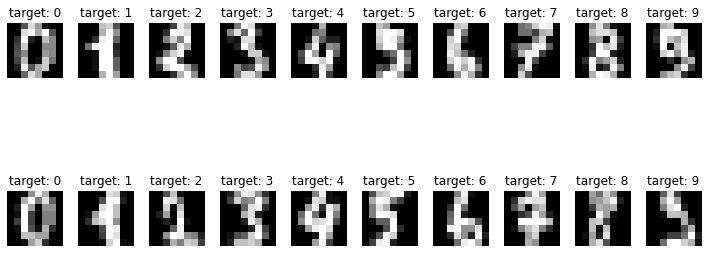

In [11]:
fig, axes = plt.subplots(2, 10, figsize=(10, 6))
for i in range(20):
    axes[i//10, i %10].imshow(mnist.images[i], cmap='gray');
    axes[i//10, i %10].axis('off')
    axes[i//10, i %10].set_title(f"target: {mnist.target[i]}")
    
plt.tight_layout()

In [12]:
total_images = images.shape[0]
n = 10
images = jax.device_put(images)  # push NumPy explicitly to GPU
labels = jax.device_put(labels) 
images = images.reshape(total_images,-1)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

### Training loop

In [14]:
# TODO: make model class
epochs = 1
layers = [X_train.shape[-1],512,256,n]

params = init_params(layers,42)
batch_size = 32
no_of_samples = X_train.shape[0]
no_of_batches = no_of_samples // batch_size

for e in range(epochs):
    total_loss = 0
    for batch_i in range(0,no_of_samples,batch_size):
        batch_end_idx = batch_i + 32 if batch_i + 32 < no_of_samples else -1
        batch_images = images[batch_i: batch_end_idx]
        batch_labels = labels[batch_i: batch_end_idx]
        batch_labels_encoded = jax.nn.one_hot(batch_labels, len(mnist['target_names']))
        # forward pass
        batch_predictions,caches = batch_forward(params,batch_images)
        # loss calculation
        batch_loss = loss(batch_predictions,batch_labels_encoded)
        total_loss += batch_loss
        # back prop and gradient calculation
        backward(caches)

        # update()
    print(total_loss)

NameError: ignored

In [266]:
caches

NameError: ignored

In [211]:
# def MLPClassfier():
#     def __init__(self,layer_sizes,seed):
#         self.parent_key = random.PRNGKey(seed)
#         self.params = []
#         self.layer_sizes = layer_sizes
#         self.n_layers = len(self.layer_sizes)
#         self._init_params()
#         self.caches = []

#     def _init_params(self,scale = 0.01):
#         keys = random.split(self.parent_key,num = self.n_layers - 1)

#         for i in range(self.n_layers-1):
#             w_key,b_key = random.split(keys[i])
#             in_size = self.layer_sizes[i]
#             out_size = self.layer_sizes[i+1]

#             w = random.normal(w_key,shape=(in_size,out_size))
#             b = random.normal(b_key,shape=(out_size,))
#             self.params.append([w,b])

#     def _linear_forward(self,activation,w,b):
#         """
#             for a single sample
#         """
#         z = np.dot(w,activation) + b 
#         cache = (activation,w,b)
#         return z, cache
    
#     def _linear_activation_forward(self,activation, w, b, activation_fn):
#         z, linear_cache = self._linear_forward(activation, w, b)
#         activation = activation_fn(z)
#         cache = (linear_cache, z)

#         return activation, cache

#     @jit
#     def _forward(self,x):
#         """
#         forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
        
#         Arguments:
#         X -- data, numpy array of shape (input size, number of examples)
#         parameters -- output of initialize_parameters_deep()
        
#         Returns:
#         AL -- last post-activation value
#         caches -- list of caches containing:
#                     every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
#                     the cache of linear_sigmoid_forward() (there is one, indexed L-1)
#         """

       
#         activation = x
#         # self.
#         L = self.n_layers                # number of layers in the neural network
    

#         hidden_layers = params[:-1]

#         # Loop over the ReLU hidden layers
#         for w, b in hidden_layers:
#             activation, cache = self._linear_activation_forward(activation, w, b, activation_fn = jax.nn.relu)
#             self.caches.append(cache)

#         # Perform final trafo to logits
#         final_w, final_b = params[-1]
#         logits = np.dot(final_w, activation) + final_b
#         output, cache = self._linear_activation_forward(activation, final_w, final_b, activation_fn = jax.nn.softmax)
#         output = jax.nn.softmax(logits)
#         self.caches.append(cache)

#         return output

#     def forward(self,X):
#         batch_forward = jit(vmap(self._forward, in_axes=(None, 0), out_axes=0))
#         return batch_forward(X)

#     def linear_backward(self, dZ, cache):
#         """
#         Implement the linear portion of backward propagation for a single layer (layer l)

#         Arguments:
#         dZ -- Gradient of the cost with respect to the linear output (of current layer l)
#         cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

#         Returns:
#         dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
#         dW -- Gradient of the cost with respect to W (current layer l), same shape as W
#         db -- Gradient of the cost with respect to b (current layer l), same shape as b
#         """
#         A_prev, W, b = cache
#         m = A_prev.shape[1]

#         ### START CODE HERE ### (≈ 3 lines of code)
#         dW = np.dot(dZ, cache[0].T) / m
#         db = np.squeeze(np.sum(dZ, axis=1, keepdims=True)) / m
#         dA_prev = np.dot(cache[1].T, dZ)
#         ### END CODE HERE ###
        
#         assert (dA_prev.shape == A_prev.shape)
#         assert (dW.shape == W.shape)
#         assert (isinstance(db, float))
        
#         return dA_prev, dW, db

In [ ]:
# forward pass
@jit
def forward(params,in_array):
    """
        Compute the forward pass for each example individually
        params: list of weights and biases of MLP 
        x: single flat image
    """
    hidden_layers = params[:-1]

    activations = in_array

    # Loop over the ReLU hidden layers
    for w, b in hidden_layers:
        a = np.dot(w,activations) + b 
        activation = jax.nn.relu(a)
    
    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    output = jax.nn.softmax(logits)
    return output


In [ ]:
def update(params,imgs,labels):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)


In [ ]:
def init_MLPClassfier(layer_sizes,parent_key,scale = 0.01):
    params = []
    keys = random.split(parent_key,num= len(layer_sizes) - 1)

    for i in range(len(layer_sizes)-1):
        w_key,b_key = random.split(keys[i])
        in_size = layer_sizes[i]
        out_size = layer_sizes[i+1]
        # print()
        w = random.normal(w_key,shape=(in_size,out_size))
        b = random.normal(b_key,shape=(out_size,))
        params.append([w,b])

    return params

In [ ]:
# test
input,h1,h2,output = (784,512,256,10)
layers = [input,h1,h2,output]
seed = 42 

parent_key = random.PRNGKey(seed)
MLP_params = init_MLPClassfier(layers,parent_key)

print(jax.tree_map(lambda x: x.shape,MLP_params))

[[(784, 512), (512,)], [(512, 256), (256,)], [(256, 10), (10,)]]
